### Import Modules

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as f


/home/andmholm/Backdoor/backdoor_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load the Data

In [2]:
# Data needs to be in Tensor format and must be normalized to make computing the gradient faster, and optimization quicker

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.1307,), (0.3081,)), ])

batch_size = 128 # amount of examples we see in data before we update

In [3]:
# with the transformer initialized, we load, shuffle, then transform the data using DataLoader class

# training data
trainset = torchvision.datasets.MNIST('./data', download=True, train=True, transform=transform)
# testing data
testset = torchvision.datasets.MNIST('./data', download=True, train=False, transform=transform)

# loading training & testing data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 64 images (each batch) of 1 channel of 28x28 pixels
print(f"shape of images: {images.shape}")
# 64 labels
print(f"shape of labels: {labels.shape}")

print(f'example imahe\n{images[0]}')

shape of images: torch.Size([64, 1, 28, 28])
shape of labels: torch.Size([64])
example imahe
tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, 

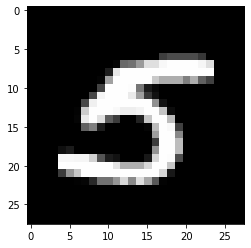

In [5]:
# displaying the image
plt.imshow(images[0].numpy().squeeze(), cmap="gray")

### Creating the Convolutional Neural Network

In [6]:


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 4, 1)
        self.conv2 = nn.Conv2d(32, 64, 4, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout(0.25)
        self.drop2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, 10)


    def forward(self, x):
        x = self.pool(f.relu(self.conv1(x)))
        x = self.pool(f.relu(self.conv2(x)))
        x = self.drop1(x)
        x = torch.flatten(x, 1)
        x = f.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)
        out = f.log_softmax(x, dim=1)
        return out

### Training 

In [7]:
def train(net, trainloader, optimizer, loss_fn, batch_size=32, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)
    net.train() # indicate to layers they're being trained on
    n = len(trainloader.dataset)

    # iterate for n epochs
    for epoch in range(epochs):

        trained = 0

        # iterate and train on each batch
        for i, data in enumerate(trainloader, 0):

            # get data, predict data, find loss, update & take a step to optimize on next iteration
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            trained += batch_size

    # display info every half of epoch
            if not (i + 1) % (len(trainloader) // 2):
                print(f"epoch: {epoch + 1} trained: {trained if trained < n else n}/{n} loss: {loss.item()}")
        print(f"epoch complete trained: {n}/{n} loss: {loss.item()}")
    print("training complete")
    net.to('cpu')
    del device



net = Net()
optimizer = torch.optim.Adadelta(net.parameters(), lr=1)
loss = f.nll_loss


### Testing

In [8]:

def test(net, testloader, loss_fn):
    net.eval()
    loss = 0
    correct = 0
    n = len(testloader.dataset)

    for i, data in enumerate(testloader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss += loss_fn(outputs, labels)
        pred = outputs.argmax(dim=1, keepdim=True)
        if i == 0:
            print(pred.size())
        correct += pred.eq(labels.view_as(pred)).sum().item()    
    loss /= n

    print(f"avg loss: {loss} acc: {correct / n}")


### Train & Test

In [9]:
train(net, trainloader, optimizer, loss, 64)

epoch: 1 trained: 30016/60000 loss: 0.1954796016216278
epoch: 1 trained: 60000/60000 loss: 0.06426367908716202
epoch complete trained: 60000/60000 loss: 0.06426367908716202
epoch: 2 trained: 30016/60000 loss: 0.008466465398669243
epoch: 2 trained: 60000/60000 loss: 0.001839307602494955
epoch complete trained: 60000/60000 loss: 0.001839307602494955
epoch: 3 trained: 30016/60000 loss: 0.013173606246709824
epoch: 3 trained: 60000/60000 loss: 0.07999547570943832
epoch complete trained: 60000/60000 loss: 0.07999547570943832
training complete


In [10]:
test(net, testloader, loss)

torch.Size([64, 1])
avg loss: 0.0006581118796020746 acc: 0.9874


### Saving & Loading Models

In [11]:
torch.save(net.state_dict(), "models/mnist_net.pth") # saving

In [12]:
net = Net() # init class of model
net.load_state_dict(torch.load("models/mnist_net.pth")) # load parameters to model

<All keys matched successfully>